# GE2017 Constituency Level Turnout Model
For more information please see the [PyData London 2019 Democracy Hackathon repo](https://github.com/john-sandall/democracy-hackathon/).

In [1]:
# Libaries that may or may not be useful
import matplotlib
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
from sklearn import ensemble, linear_model, metrics, model_selection, neural_network, tree

import maven

# Config
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
DATA_DIR = Path('../data/')
%matplotlib inline

### Import model-ready General Election data for 2010 and 2015

In [2]:
maven.get('general-election/UK/2015/model', data_directory='./data/')

Exporting 2010->2015 model dataset to /Users/john/code/sixfifty/hackathon/model/data/general-election/UK/2015/model/processed
Exporting 2015->2017 model dataset to /Users/john/code/sixfifty/hackathon/model/data/general-election/UK/2015/model/processed


In [3]:
df = pd.read_csv('data/general-election/UK/2015/model/processed/general_election-uk-2015-model.csv')
df.head(15)

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last,turnout
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.608954
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
5,2.0,Aberconwy,Wales,44593.0,29966,con,10734.0,0.358206,con,0.338182,-0.062021,0.335990,con,con,0.415052,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.671989
6,2.0,Aberconwy,Wales,44593.0,29966,lab,7336.0,0.244811,con,0.337273,0.163400,0.284813,con,con,0.282407,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
7,2.0,Aberconwy,Wales,44593.0,29966,ld,5786.0,0.193085,con,0.090000,-0.609159,0.075466,con,con,0.046139,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
8,2.0,Aberconwy,Wales,44593.0,29966,ukip,632.0,0.021091,con,0.127273,3.109344,0.086668,con,con,0.114999,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989
9,2.0,Aberconwy,Wales,44593.0,29966,grn,0.0,0.000000,con,0.048182,4.008203,0.000000,con,con,0.024114,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.671989


In [4]:
parties = ['con', 'lab', 'ld', 'ukip', 'grn']

/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/usr/local/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


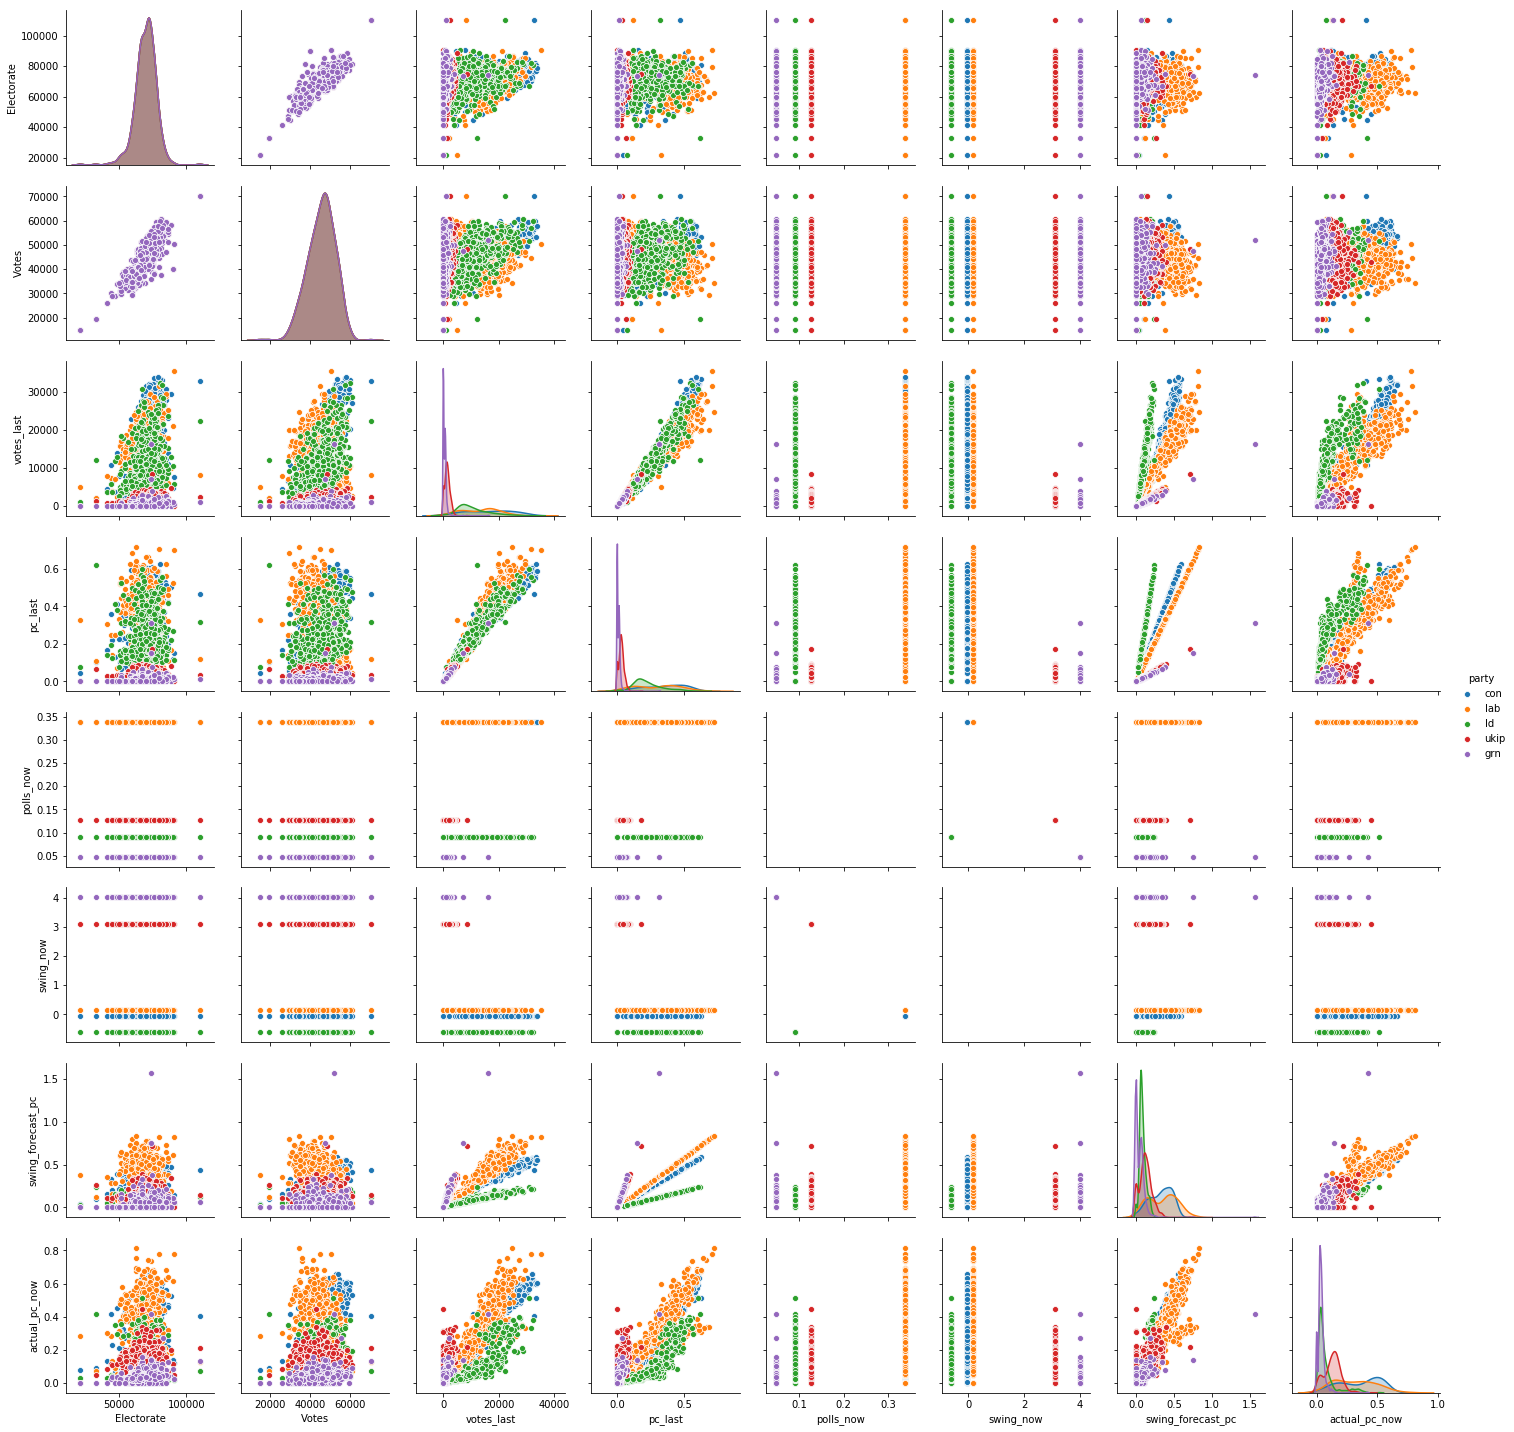

In [5]:
# Visualise feature relationships
sns.pairplot(
    df[['Electorate', 'Votes', 'votes_last', 'pc_last', 'polls_now',
        'swing_now', 'swing_forecast_pc', 'actual_pc_now', 'party']],
    hue='party')

In [6]:
# Some useful functions
def score_model(model, X, y, repeats=5):
    """Calculates a "5x5" (repeated 5-fold) cross-validated shuffled mean average error.
       Returns the mean across 5 (default) repeats."""
    mmae = []
    for i in range(repeats):
        mmae += [-np.mean(model_selection.cross_val_score(model, X=X, y=y, cv=model_selection.KFold(n_splits=5, shuffle=True), scoring='neg_mean_absolute_error'))]
    return np.mean(mmae)

def score_features(model, features):
    """Helper function to run scoring function for a feature subset and using turnout.
       This equates to average turnout error per seat."""
    return score_model(model=model, X=df[features], y=df['turnout'])

### UNS model
Uniform National Swing has been pre-calculated here for you ("`swing_now`" and "`swing_forecast_pc`"). Let's evaluate how many seats are won by each party in 2015 according to this approach.

In [7]:
df.head()

,Press Association Reference,Constituency Name,Region,Electorate,Votes,party,votes_last,pc_last,win_last,polls_now,swing_now,swing_forecast_pc,swing_forecast_win,actual_win_now,actual_pc_now,con,grn,lab,ld,ukip,Region_East Midlands,Region_Eastern,Region_London,Region_North East,Region_North West,Region_Northern Ireland,Region_Scotland,Region_South East,Region_South West,Region_Wales,Region_West Midlands,Region_Yorkshire and the Humber,won_here_last,turnout
0,1.0,Aberavon,Wales,50838.0,30958,con,4411.0,0.142483,lab,0.338182,-0.062021,0.133646,lab,lab,0.118707,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
1,1.0,Aberavon,Wales,50838.0,30958,lab,16073.0,0.519187,lab,0.337273,0.163400,0.604022,lab,lab,0.489040,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0.608954
2,1.0,Aberavon,Wales,50838.0,30958,ld,5034.0,0.162607,lab,0.090000,-0.609159,0.063554,lab,lab,0.044317,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
3,1.0,Aberavon,Wales,50838.0,30958,ukip,489.0,0.015796,lab,0.127273,3.109344,0.064910,lab,lab,0.157694,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954
4,1.0,Aberavon,Wales,50838.0,30958,grn,0.0,0.000000,lab,0.048182,4.008203,0.000000,lab,lab,0.022555,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0.608954


In [8]:
# Seats won in 2010
(df[['Constituency Name', 'win_last']]
    .drop_duplicates()
    .groupby('win_last')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
win_last,
con,306
lab,258
ld,57
dup,8
snp,6
sf,5
pc,3
sdlp,3
APNI,1


In [9]:
# Seats forecast to win in 2015 using UNS model
(df[['Constituency Name', 'swing_forecast_win']]
    .drop_duplicates()
    .groupby('swing_forecast_win')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
swing_forecast_win,
lab,326
con,297
other,21
grn,3
ld,2
ukip,1


In [10]:
# Seats actually won in 2015 (from election results)
(df[['Constituency Name', 'actual_win_now']]
    .drop_duplicates()
    .groupby('actual_win_now')
    .count()
    .sort_values('Constituency Name', ascending=False)
)

,Constituency Name
actual_win_now,
con,330
lab,232
snp,56
DUP,8
ld,8
SF,4
SDLP,3
pc,3
UUP,2


In [11]:
# Turnout in 2015
df[['Constituency Name', 'turnout']].groupby('Constituency Name').mean().reset_index().head(20)

,Constituency Name,turnout
0,Aberavon,0.608954
1,Aberconwy,0.671989
2,Aberdeen North,0.581734
3,Aberdeen South,0.672081
4,Aberdeenshire West & Kincardine,0.683633
5,Airdrie & Shotts,0.574835
6,Aldershot,0.635052
7,Aldridge-Brownhills,0.655825
8,Altrincham & Sale West,0.684038
9,Alyn & Deeside,0.655217


### Simple ML model

In [12]:
df = df.groupby(['Press Association Reference', 'Constituency Name']).head(1).reset_index()[
    ['Press Association Reference', 'Constituency Name', 'Region', 'Electorate', 'Votes',
     'win_last', 'swing_forecast_win', 'actual_win_now'] + 
    ['Region_' + x for x in df.Region.unique()[1:]] + ['turnout']
]

In [13]:
model = linear_model.LinearRegression()

In [14]:
# Available features
df.columns

Index(['Press Association Reference', 'Constituency Name', 'Region',
       'Electorate', 'Votes', 'win_last', 'swing_forecast_win',
       'actual_win_now', 'Region_Scotland', 'Region_South East',
       'Region_West Midlands', 'Region_North West', 'Region_East Midlands',
       'Region_Northern Ireland', 'Region_London',
       'Region_Yorkshire and the Humber', 'Region_Eastern',
       'Region_South West', 'Region_North East', 'turnout'],
      dtype='object')

In [15]:
# Useable features
features = (
    ['Electorate', 'Votes'] +
    # 'win_last', 'swing_forecast_win', 'actual_win_now' need to be dummied before they can be used
    ['Region_' + x for x in df.Region.unique()[1:]]
)
target = 'turnout'

In [16]:
# 0.3% average error per seat
score_features(
    model=model,
    features=features
)

0.003937009604205668

# Over to you...!

In [17]:
# Model away...